### Transfer Learning for Image Classification <br>
**Problem:** Training a deep neural network on a large dataset takes a lot of time. So, is there a way, we create a network which performs excellent on our dataset as well as we do not have to train for long time? <br>

**Solution:** Transfer Learning. <br>

**Transfer Learning:**<br>
Transfer Learning is the method where a model trained for one problem is used for another similar problem on which the model is not trained. <br>

For example, we have a VGG model that is trained on ImageNet dataset with excellent scores. Now, we have another dataset that is different from ImageNet but it also involves classification of images, so we can use the pretrained VGG model for our dataset without training on our dataset. <br>

In the above example we are using the trained model as it is for classification. <br>
There are other approaches of transfer learning as well:
* Use the pre-trained model's initial layers as feature extractor and then feed the features to a classifier. <br>
* Use the pre-trained model's initial layers and add more layers according to your need and train the model only for newly added layers i.e. freeze the layers of pretrained model.
* Use the pre-trained model's layers and add more layers according to your need and train the whole network. The benefit of this is that the weights are not randomly intialized rather they are fine tuned weights. <br>

**Why would this work?** <br>
We know that the neural networks perform feature extraction or learn representations before the final classification layers. <br>

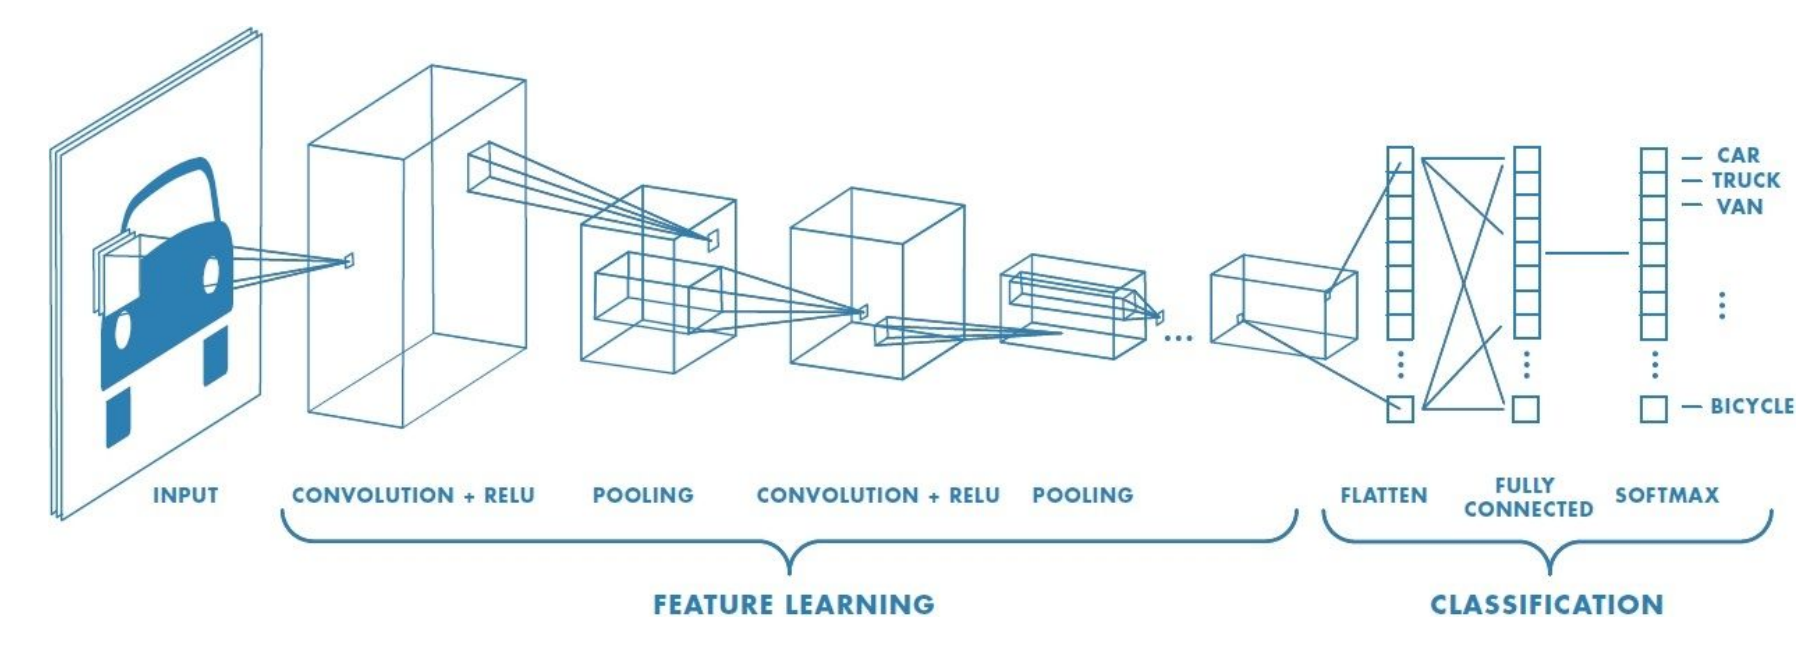

* The first layers learn simple features which are common to all objects like edges, simple textures.
* Later layers learn more complex features like complex textures and patterns.
* The last layers learn features such as objects or parts of objects. <br>

So, for similar problems, we expect that the features will also be similar till last layers, but if they are quite different, the features in starting few layers will be same and we can use them. That's why transfer learning works and makes our lives easier.

Now let's start. In this tutorial we will use VGG16 pretrained model and exclude the last classification layer. We can add new layers at the end like Conv and Pooling layers or only a FC classification layer according to our data and train. We will only use a classification layer and see how it performs without training and with training for few epochs.

Load VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [ ]:
# load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

The built in VGG model of keras is created using Functional API, we used Sequential models previously where we added layers calling model's `add()` function. In Functional model, we add layers on top of a specific layer from previous layers as done in the above code block.

In [ ]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

Now we will train the model. The model is loaded with pretrained weights on ImageNet, so the layers other than classification layers (that we have added) have learned weights. So, we expect that only training for few epochs will give good results.
Let's check it.

Load Data

In [ ]:
# necessary imports
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [ ]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (150, 150))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [ ]:
train_dir = "data/intel-image-classification-mini/seg_train/"
test_dir = "data/intel-image-classification-mini/seg_test/"
pred_dir = "data/intel-image-classification-mini/seg_pred/"

In [ ]:
print('loading train images')
X_train, y_train = load_data(train_dir)
print('loading test images')
X_test, y_test = load_data(test_dir)

loading train images


100%|██████████| 1135/1135 [08:48<00:00,  2.15it/s]


loading test images


100%|██████████| 501/501 [03:42<00:00,  2.25it/s]


In [ ]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
from sklearn.model_selection import train_test_split
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train,
                                                        test_size=0.2,
                                                        random_state=42)

Compile the model

In [ ]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

Train the model

In [ ]:
H = model.fit(X_train, y_train, batch_size=128,
              epochs=10, 
              validation_data=(X_valid, y_valid))

Epoch 1/10
44/44 [==============================] - 47s 1s/step - loss: 0.8680 - accuracy: 0.6698 - val_loss: 0.3855 - val_accuracy: 0.8704
Epoch 2/10
44/44 [==============================] - 38s 862ms/step - loss: 0.3487 - accuracy: 0.8719 - val_loss: 0.2866 - val_accuracy: 0.9031
Epoch 3/10
44/44 [==============================] - 38s 873ms/step - loss: 0.2241 - accuracy: 0.9212 - val_loss: 0.2519 - val_accuracy: 0.9174
Epoch 4/10
44/44 [==============================] - 38s 867ms/step - loss: 0.1790 - accuracy: 0.9364 - val_loss: 0.2372 - val_accuracy: 0.9217
Epoch 5/10
44/44 [==============================] - 38s 871ms/step - loss: 0.1362 - accuracy: 0.9558 - val_loss: 0.2406 - val_accuracy: 0.9152
Epoch 6/10
44/44 [==============================] - 38s 872ms/step - loss: 0.0839 - accuracy: 0.9751 - val_loss: 0.2700 - val_accuracy: 0.9138
Epoch 7/10
44/44 [==============================] - 38s 872ms/step - loss: 0.0586 - accuracy: 0.9829 - val_loss: 0.2588 - val_accuracy: 0.9167
Ep

In [ ]:
# save the model's trained weights
model.save_weights('vgg_transfer_trained_wts.h5')

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 8s 160ms/step - loss: 0.3985 - accuracy: 0.8957
Test Loss =  0.398506224155426
Test Accuracy =  0.8956666588783264


In [ ]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

In [ ]:
confusion_mtx

array([[403,   1,   2,   0,   3,  28],
       [  0, 469,   4,   0,   0,   1],
       [  2,   4, 508,  26,  11,   2],
       [  0,   2, 114, 402,   5,   2],
       [  4,   3,  43,   7, 451,   2],
       [ 40,   2,   2,   2,   1, 454]])

Here we can see that the performance has increased a lot. In the previous [tutorial](https://github.com/visionatseecs/keras-starter/blob/main/keras_vgg.ipynb), we had trained VGG16 from scratch and for 50 epochs but the performance (accuracy) on test set was only 58%. Now we have used transfer learning technique here and trained only for 10 epochs and we see that we have got 89% accuracy which is great improvement.